In [ ]:
import os
import glob
import cv2

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import pandas as pd
import gc
import string
import time
import time
import random
import imutils
from PIL import Image
from tqdm import tqdm
tqdm.pandas()

In [ ]:
import matplotlib
import matplotlib.pyplot as plt
import plotly
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
from sklearn.manifold import TSNE

In [ ]:
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Dense, Flatten, Dropout
from keras.models import load_model, Model
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping

In [ ]:
#Configuration
class CFG:
    batch_size = 64
    img_height = 64
    img_width = 64
    epochs = 10
    num_classes = 29
    img_channels =3

def seed_everything(seed: int):
    random.seed(seed)
    os.environ["PYTHONHASHSEED"]  = str(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)

In [15]:
TRAIN_PATH = "/content/asl_alphabet_train/asl_alphabet_train"
labels = []
alphabet = list(string.ascii_uppercase)
labels.extend(alphabet)
labels.extend(["del","nothing","space"])
print(labels)

['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'del', 'nothing', 'space']


In [16]:
list_path = []
list_labels = []

for label in labels:
    label_path = os.path.join(TRAIN_PATH, label, "*")
    image_files = glob.glob(label_path)

    sign_label=[label]* len(image_files)

    list_path.extend(image_files)
    list_labels.extend(sign_label)

metadata=pd.DataFrame({

    "image_path":list_path,
    "label":list_labels
})

metadata

,image_path,label
0,/content/asl_alphabet_train/asl_alphabet_train...,A
1,/content/asl_alphabet_train/asl_alphabet_train...,A
2,/content/asl_alphabet_train/asl_alphabet_train...,A
3,/content/asl_alphabet_train/asl_alphabet_train...,A
4,/content/asl_alphabet_train/asl_alphabet_train...,A
...,...,...
86995,/content/asl_alphabet_train/asl_alphabet_train...,space
86996,/content/asl_alphabet_train/asl_alphabet_train...,space
86997,/content/asl_alphabet_train/asl_alphabet_train...,space
86998,/content/asl_alphabet_train/asl_alphabet_train...,space


In [17]:
X_train, X_test, y_train, y_test = train_test_split(
    metadata["image_path"],metadata["label"],
    test_size=0.15,
    random_state=2023,shuffle=True,
    stratify=metadata["label"]
)

data_train = pd.DataFrame({
    "image_path": X_train,
    "label": y_train
})

X_train, X_val, y_train, y_val = train_test_split(
    data_train["image_path"], data_train["label"],
    test_size=0.15/0.70,
    random_state=2023,
    shuffle=True,
    stratify=data_train["label"]
)

data_train = pd.DataFrame({
    "image_path": X_train,
    "label": y_train
})

data_val = pd.DataFrame({
    "image_path": X_val,
    "label": y_val
})

data_test = pd.DataFrame({
    "image_path": X_test,
    "label": y_test
})

display(data_train)
display(data_val)
display(data_test)

,image_path,label
51901,/content/asl_alphabet_train/asl_alphabet_train...,R
51887,/content/asl_alphabet_train/asl_alphabet_train...,R
5050,/content/asl_alphabet_train/asl_alphabet_train...,B
29446,/content/asl_alphabet_train/asl_alphabet_train...,J
58405,/content/asl_alphabet_train/asl_alphabet_train...,T
...,...,...
47111,/content/asl_alphabet_train/asl_alphabet_train...,P
83611,/content/asl_alphabet_train/asl_alphabet_train...,nothing
67329,/content/asl_alphabet_train/asl_alphabet_train...,W
85296,/content/asl_alphabet_train/asl_alphabet_train...,space


,image_path,label
24961,/content/asl_alphabet_train/asl_alphabet_train...,I
71053,/content/asl_alphabet_train/asl_alphabet_train...,X
73637,/content/asl_alphabet_train/asl_alphabet_train...,Y
72875,/content/asl_alphabet_train/asl_alphabet_train...,Y
40669,/content/asl_alphabet_train/asl_alphabet_train...,N
...,...,...
16474,/content/asl_alphabet_train/asl_alphabet_train...,F
62741,/content/asl_alphabet_train/asl_alphabet_train...,U
32281,/content/asl_alphabet_train/asl_alphabet_train...,K
20451,/content/asl_alphabet_train/asl_alphabet_train...,G


,image_path,label
73327,/content/asl_alphabet_train/asl_alphabet_train...,Y
85482,/content/asl_alphabet_train/asl_alphabet_train...,space
65607,/content/asl_alphabet_train/asl_alphabet_train...,V
53903,/content/asl_alphabet_train/asl_alphabet_train...,R
64425,/content/asl_alphabet_train/asl_alphabet_train...,V
...,...,...
40578,/content/asl_alphabet_train/asl_alphabet_train...,N
28949,/content/asl_alphabet_train/asl_alphabet_train...,J
42094,/content/asl_alphabet_train/asl_alphabet_train...,O
5425,/content/asl_alphabet_train/asl_alphabet_train...,B


In [22]:
#Data Augmentation (Just Rescale)
def data_augmentation():
    datagen = ImageDataGenerator(rescale=1/255.,)
    #Training Dataset
    train_generator = datagen.flow_from_dataframe(
        data_train,
        directory="./",
        x_col="image_path",
        y_col="label",
        class_mode="categorical",
        batch_size=CFG.batch_size,
        target_size=(CFG.img_height,CFG.img_width)
    )

    #Validation Dataset
    validtion_generator = datagen.flow_from_dataframe(
        data_val,
        directory="./",
        x_col="image_path",
        y_col="label",
        class_mode="categorical",
        batch_size=CFG.batch_size,
        target_size=(CFG.img_height,CFG.img_width)

    )

    # Validation Dataset
    validation_generator = datagen.flow_from_dataframe(
        data_val,
        directory="./",
        x_col="image_path",
        y_col="label",
        class_mode="categorical",
        batch_size=CFG.batch_size,
        target_size=(CFG.img_height, CFG.img_width),
    )

    # Testing Dataset
    test_generator = datagen.flow_from_dataframe(
        data_test,
        directory="./",
        x_col="image_path",
        y_col="label",
        class_mode="categorical",
        batch_size=1,
        target_size=(CFG.img_height, CFG.img_width),
        shuffle=False
    )

    return train_generator, validation_generator, test_generator

In [23]:
seed_everything(2023)
train_generator, validation_generator, test_generator = data_augmentation()

Found 58103 validated image filenames belonging to 29 classes.
Found 15847 validated image filenames belonging to 29 classes.
Found 15847 validated image filenames belonging to 29 classes.
Found 13050 validated image filenames belonging to 29 classes.


58889256/58889256 [==============================] - 3s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 64, 64, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 64, 64, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 32, 32, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 32, 32, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 32, 32, 128)       147584    
                                                              

None

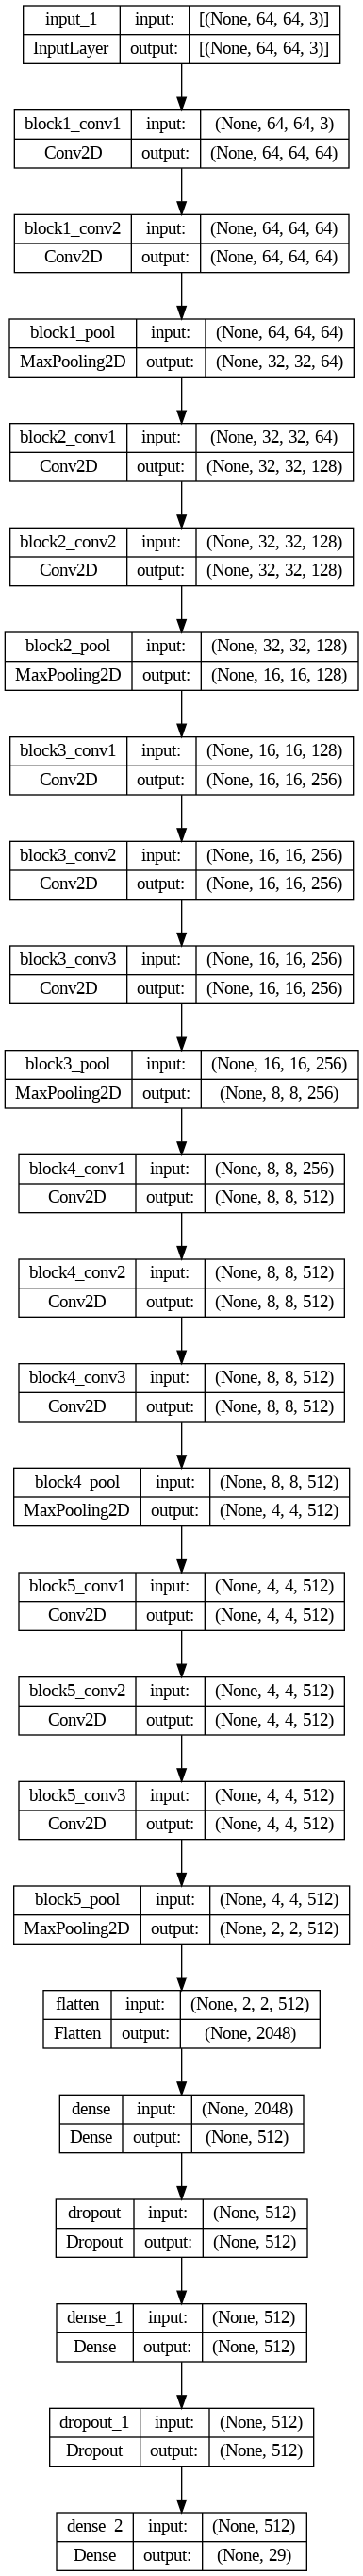

In [19]:
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(CFG.img_height, CFG.img_width, CFG.img_channels))

for layer in base_model.layers:
    layer.trainable = False

x = base_model.output
x = Flatten()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(29, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

display(model.summary())
display(tf.keras.utils.plot_model(model, to_file='vgg16.png', show_shapes=True))

In [20]:
# Compile and train the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# Callbacks
checkpoint = ModelCheckpoint('asl_vgg16_best_weights.h5', save_best_only=True, monitor='val_accuracy', mode='max')

In [24]:
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // CFG.batch_size,
    epochs=CFG.epochs,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // CFG.batch_size,
    callbacks=[checkpoint]
)

Epoch 1/10
907/907 [==============================] - 131s 135ms/step - loss: 1.0971 - accuracy: 0.6547 - val_loss: 0.2542 - val_accuracy: 0.9299
Epoch 2/10
907/907 [==============================] - 123s 135ms/step - loss: 0.3924 - accuracy: 0.8655 - val_loss: 0.1313 - val_accuracy: 0.9633
Epoch 3/10
907/907 [==============================] - 122s 135ms/step - loss: 0.2854 - accuracy: 0.9035 - val_loss: 0.0899 - val_accuracy: 0.9726
Epoch 4/10
907/907 [==============================] - 123s 135ms/step - loss: 0.2432 - accuracy: 0.9157 - val_loss: 0.0698 - val_accuracy: 0.9809
Epoch 5/10
907/907 [==============================] - 102s 113ms/step - loss: 0.2138 - accuracy: 0.9267 - val_loss: 0.0520 - val_accuracy: 0.9846
Epoch 6/10
907/907 [==============================] - 101s 112ms/step - loss: 0.1904 - accuracy: 0.9346 - val_loss: 0.0626 - val_accuracy: 0.9812
Epoch 7/10
907/907 [==============================] - 102s 112ms/step - loss: 0.1788 - accuracy: 0.9379 - val_loss: 0.0419 -

In [25]:
model.save('Trained_Model.h5')

In [26]:
# Recreate the exact same model, including its weights and the optimizer
new_model = tf.keras.models.load_model('Trained_Model.h5')

# Show the model architecture
new_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 64, 64, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 64, 64, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 32, 32, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 32, 32, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 32, 32, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 16, 16, 128)       0     

In [27]:
scores = model.evaluate(test_generator)
print("%s: %.2f%%" % ("Evaluate Test Accuracy", scores[1]*100))

13050/13050 [==============================] - 86s 7ms/step - loss: 0.0459 - accuracy: 0.9846
Evaluate Test Accuracy: 98.46%


In [28]:
# Visualize Training and Validation Results

# Create Subplot
fig = make_subplots(
        rows=1, cols=2,
        subplot_titles=["Model Loss", "Model Accuracy"],
)

# Configuration Plot
class PlotCFG:
    marker_size = 8
    line_size = 2
    train_color = "#76503d"
    valid_color = "#deb392"

# Loss Plot
loss = history.history['loss']
val_loss = history.history['val_loss']
fig.add_trace(
    go.Scatter(
        x=np.arange(1, len(loss)+1), y=loss,
        mode="markers+lines",
        marker=dict(
            color=PlotCFG.train_color, size=PlotCFG.marker_size,
            line=dict(color="White", width=0.5)
        ),
        line=dict(color=PlotCFG.train_color, width=PlotCFG.line_size),
        name="Training Loss"
    ), row=1, col=1
)
fig.add_trace(
    go.Scatter(
        x=np.arange(1, len(val_loss)+1), y=val_loss,
        mode="markers+lines",
        marker=dict(
            color=PlotCFG.valid_color, size=PlotCFG.marker_size,
            line=dict(color="White", width=0.5)
        ),
        line=dict(color=PlotCFG.valid_color, width=PlotCFG.line_size),
        name="Validation Loss"
    ), row=1, col=1
)

# Accuracy Plot
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
fig.add_trace(
    go.Scatter(
        x=np.arange(1, len(acc)+1), y=acc,
        mode="markers+lines",
        marker=dict(
            color=PlotCFG.train_color, size=PlotCFG.marker_size,
            line=dict(color="White", width=0.5)
        ),
        line=dict(color=PlotCFG.train_color, width=PlotCFG.line_size),
        name="Training Accuracy"
    ), row=1, col=2
)
fig.add_trace(
    go.Scatter(
        x=np.arange(1, len(val_acc)+1), y=val_acc,
        mode="markers+lines",
        marker=dict(
            color=PlotCFG.valid_color, size=PlotCFG.marker_size,
            line=dict(color="White", width=0.5)
        ),
        line=dict(color=PlotCFG.valid_color, width=PlotCFG.line_size),
        name="Validation Accuracy"
    ), row=1, col=2
)

# Update Axes
fig.update_xaxes(title="Epochs", linecolor="Black", ticks="outside", row=1, col=1)
fig.update_xaxes(title="Epochs", linecolor="Black", ticks="outside", row=1, col=2)
fig.update_yaxes(title="Categorical Loss", linecolor="Black", ticks="outside", row=1, col=1)
fig.update_yaxes(title="Accuracy", linecolor="Black", ticks="outside", row=1, col=2)

# Update Layout
fig.update_layout(
    title="Training Loss and Metrics", title_x=0.5,
    width=950, height=400,
    showlegend=False,
    plot_bgcolor="White",
    paper_bgcolor="White"
)

# Show
fig.show(iframe_connected=True)

In [30]:
# Confusion Matrix
fine_tuned_model = load_model("Trained_Model.h5")
predictions = fine_tuned_model.predict(test_generator)

# Get the true labels from the generator
true_labels = test_generator.classes

# Compute the confusion matrix using tf.math.confusion_matrix
confusion_matrix = tf.math.confusion_matrix(
        labels=true_labels,
        predictions=predictions.argmax(axis=1),
        num_classes=29)

13050/13050 [==============================] - 64s 5ms/step


In [31]:
# Create Figure
fig = go.Figure()

# Heatmap
fig.add_trace(
    go.Heatmap(
        z=confusion_matrix,
        x=labels,
        y=labels,
        text=confusion_matrix,
        texttemplate="<b>%{text}</b>",
        textfont={"size":8},
        colorscale=[[0, '#f4f4f4'],[1.0, '#76503d']],
        showscale = False,
        ygap = 5,
        xgap = 5,
        hovertemplate=
        '''
        Actual: %{y}<br>
        Predicted: %{x}<br>
        Total: %{text}
        ''',
        name="Confusion Matrix"
    )
)

# Update Axes
fig.update_xaxes(title="<b>Predicted Values</b>", tickfont_size=10)
fig.update_yaxes(title="<b>Actual Values</b>", tickfont_size=10)

# Update Layout
fig.update_layout(title_text='Confusion Matrix', title_x=0.5, font_size=14,
                  width=1050,
                  height=1115,
                  plot_bgcolor='white',
                  showlegend=False,
)

# Show
fig.show()